## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# data import
df_s = pd.read_csv('df_s_convex_concave.csv')
df_s_true = pd.read_csv('df_s_true_convex_concave.csv')
df_t = pd.read_csv('df_t_convex_concave.csv')
df_t_true = pd.read_csv('df_t_true_convex_concave.csv')
df_t_labeled = pd.read_csv('df_t_labeled_true_convex_concave.csv')
for i in range(4):
    exec(f"df_t{i} = pd.read_csv('df_t{i}_convex_concave.csv')")

In [3]:
# data preprocessing
x_s = torch.tensor(df_s['X']).reshape(-1,1).type(torch.float32)
x_t =torch.tensor(df_t['X']).reshape(-1,1).type(torch.float32)
x_t_labeled =torch.tensor(df_t_labeled['X']).reshape(-1,1).type(torch.float32)
y_s = torch.tensor(df_s['Y']).reshape(-1,1).type(torch.float32)
y_t =torch.tensor(df_t['Y']).reshape(-1,1).type(torch.float32)
y_t_labeled =torch.tensor(df_t_labeled['Y']).reshape(-1,1).type(torch.float32)
y_s_true = torch.tensor(df_s_true['Y']).reshape(-1,1).type(torch.float32)
y_t_true =torch.tensor(df_t_true['Y']).reshape(-1,1).type(torch.float32)
for i in range(4):
    exec(f"x_t{i} = torch.tensor(df_t{i}['X']).reshape(-1,1).type(torch.float32)")
    temp_list = [0 for inner_i in range(6)]
    temp_list[i] = 1
    temp_matrix = [temp_list for inner_j in range(len(eval(f"x_t{i}")))]
    temp_matrix = torch.tensor(temp_matrix)
    exec(f"x_t{i} = torch.cat([x_t{i}, temp_matrix], axis=1).type(torch.float32)")
    exec(f"y_t{i} = copy.deepcopy(y_s)")
x_t4 = copy.deepcopy(x_s)
temp_list = [0 for inner_i in range(6)]
temp_list[4] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t4))]
temp_matrix = torch.tensor(temp_matrix)
x_t4 = torch.cat([x_t4, temp_matrix], axis=1).type(torch.float32)
y_t4 = copy.deepcopy(y_s)

temp_list = [0 for inner_i in range(6)]
temp_list[5] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t))]
temp_matrix = torch.tensor(temp_matrix)
x_t = torch.cat([x_t, temp_matrix], axis=1).type(torch.float32)

temp_list = [0 for inner_i in range(6)]
temp_list[5] = 1
temp_matrix = [temp_list for inner_j in range(len(x_t_labeled))]
temp_matrix = torch.tensor(temp_matrix)
x_t_labeled = torch.cat([x_t_labeled, temp_matrix], axis=1).type(torch.float32)

## DARC

In [4]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.fe = nn.Linear(1+(4+1+1), 40)
        self.mid1 = nn.Linear(40,40)
        self.mid2 = nn.Linear(40,40)
        self.mid4 = nn.Linear(40, 1)
        self.relu = nn.ReLU()


    def forward_one(self, x):
        x = self.fe(x)
        x = self.relu(x)
        x = self.mid1(x)
        x = self.relu(x)
        x = self.mid2(x)
        x = self.relu(x)
        x = self.mid4(x)
        x = self.relu(x)
        
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        return out1, out2

### Meta-Learning

In [7]:
experiment_num = 5
darc_original_vc_result = []
for experiment_i in tqdm(range(experiment_num)):
    model = Siamese()

    # Set the Training Parameters
    lr = 1e-3
    best_model = copy.deepcopy(model)
    best_loss = 10000000

    total_domain_num = 4 + 1 + 1
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    bn = 30*total_domain_num//2

    total_x = x_t_labeled
    total_y = y_t_labeled
    # sample = random.sample(range(len(eval(f"x_t{i}"))), bn)
    for i in range(total_domain_num - 1):
        total_x = torch.cat([total_x, eval(f"x_t{i}")],axis=0)
        total_y = torch.cat([total_y, eval(f"y_t{i}")],axis=0)

    for outer_epoch in range(10000):
        temp_loss = 0
        for inner_epoch in range(5):

            sample1 = random.sample(range(len(total_x)), bn)
            sample2 = random.sample(range(len(total_x)), bn)
            
            xi = total_x[sample1]
            xj = total_x[sample2]
            yi = total_y[sample1]
            yj = total_y[sample2]

            optimizer.zero_grad()
            y_dist = torch.abs(yi - yj)
            z1,z2 = model(xi, xj)
            distance = F.pairwise_distance(z1,z2,keepdim=True)


            psp_loss = torch.abs(y_dist - distance).mean()    
            psp_loss.backward()
            optimizer.step()
            temp_loss += psp_loss
                
        if outer_epoch % 100 == 99:
            print(f"epoch : {outer_epoch}, train loss : {temp_loss.detach().item()/5}")
        
    MLPR = MLPRegressor(hidden_layer_sizes=(30,30), validation_fraction=0.1)
    # MLPR = LinearRegression()
    latent_source_x = torch.tensor([])
    latent_source_y = torch.tensor([])
    for i in range(5):
        latent_source_x = torch.cat([latent_source_x, model.forward(eval(f"x_t{i}"), eval(f"x_t{i}"))[0].detach()], axis=0)
        latent_source_y = torch.cat([latent_source_y, eval(f"y_t{i}")], axis=0)
    latent_source_x = torch.cat([latent_source_x, model.forward(x_t_labeled, x_t_labeled)[0].detach()], axis=0)
    latent_source_y = torch.cat([latent_source_y, y_t_labeled], axis=0)
    latent_source_x = np.array(latent_source_x)
    latent_source_y = np.array(latent_source_y)
    latent_target_x = model.forward(x_t, x_t)[0].detach().numpy()

    MLPR.fit(latent_source_x, latent_source_y)
    print(f"test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t)}, denoised test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t_true)}")

    darc_original_vc_result.append([mean_squared_error(MLPR.predict(latent_target_x), y_t),mean_squared_error(MLPR.predict(latent_target_x), y_t_true)])
    pd.DataFrame(MLPR.predict(latent_source_x), columns=['y_hat']).to_csv(f'DARC_SDE_VC_MODEL{experiment_i}.csv', index=0)
    pd.DataFrame(darc_original_vc_result, columns=['TEST MSE', 'DENOISE TEST MSE']).to_csv('DARC_SDE_VC_RESULT.csv', index=0)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch : 99, train loss : 0.4664637088775635
epoch : 199, train loss : 0.3713644027709961
epoch : 299, train loss : 0.32268490791320803
epoch : 399, train loss : 0.28070640563964844
epoch : 499, train loss : 0.2907490015029907
epoch : 599, train loss : 0.2840322256088257
epoch : 699, train loss : 0.28673102855682375
epoch : 799, train loss : 0.2949745893478394
epoch : 899, train loss : 0.24775295257568358
epoch : 999, train loss : 0.2534280776977539
epoch : 1099, train loss : 0.23810949325561523
epoch : 1199, train loss : 0.2667531490325928
epoch : 1299, train loss : 0.24943766593933106
epoch : 1399, train loss : 0.25471546649932864
epoch : 1499, train loss : 0.2338693618774414
epoch : 1599, train loss : 0.23878076076507568
epoch : 1699, train loss : 0.2560886859893799
epoch : 1799, train loss : 0.21921908855438232
epoch : 1899, train loss : 0.20775954723358153
epoch : 1999, train loss : 0.21591598987579347
epoch : 2099, train loss : 0.2335336685180664
epoch : 2199, train loss : 0.20576

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|██        | 1/5 [01:48<07:14, 108.65s/it]

epoch : 9999, train loss : 0.16991500854492186
test mse : 0.05422433838248253, denoised test mse : 0.04532165825366974
epoch : 99, train loss : 0.47492399215698244
epoch : 199, train loss : 0.34041481018066405
epoch : 299, train loss : 0.34768362045288087
epoch : 399, train loss : 0.28487329483032225
epoch : 499, train loss : 0.29349517822265625
epoch : 599, train loss : 0.26111159324645994
epoch : 699, train loss : 0.27359704971313475
epoch : 799, train loss : 0.2815948724746704
epoch : 899, train loss : 0.2555140495300293
epoch : 999, train loss : 0.24790019989013673
epoch : 1099, train loss : 0.23958616256713866
epoch : 1199, train loss : 0.22506821155548096
epoch : 1299, train loss : 0.22427723407745362
epoch : 1399, train loss : 0.24655938148498535
epoch : 1499, train loss : 0.21428978443145752
epoch : 1599, train loss : 0.2230607032775879
epoch : 1699, train loss : 0.1952255368232727
epoch : 1799, train loss : 0.23177309036254884
epoch : 1899, train loss : 0.2120968818664551
epoc

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 40%|████      | 2/5 [04:26<06:52, 137.33s/it]

epoch : 9999, train loss : 0.15841726064682007
test mse : 0.03861885517835617, denoised test mse : 0.028042005375027657
epoch : 99, train loss : 0.5468299865722657
epoch : 199, train loss : 0.34146411418914796
epoch : 299, train loss : 0.29128460884094237
epoch : 399, train loss : 0.2967111110687256
epoch : 499, train loss : 0.269235897064209
epoch : 599, train loss : 0.24148991107940673
epoch : 699, train loss : 0.2448526382446289
epoch : 799, train loss : 0.22320873737335206
epoch : 899, train loss : 0.23015799522399902
epoch : 999, train loss : 0.20366501808166504
epoch : 1099, train loss : 0.2022231101989746
epoch : 1199, train loss : 0.19021589756011964
epoch : 1299, train loss : 0.21706840991973878
epoch : 1399, train loss : 0.17232600450515748
epoch : 1499, train loss : 0.1919347643852234
epoch : 1599, train loss : 0.17784684896469116
epoch : 1699, train loss : 0.1841559886932373
epoch : 1799, train loss : 0.18628140687942504
epoch : 1899, train loss : 0.18013516664505005
epoch 

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 60%|██████    | 3/5 [07:22<05:10, 155.33s/it]

epoch : 9999, train loss : 0.15512642860412598
test mse : 0.049768511205911636, denoised test mse : 0.040353067219257355
epoch : 99, train loss : 0.8339129447937011
epoch : 199, train loss : 0.8584957122802734
epoch : 299, train loss : 0.7637893676757812
epoch : 399, train loss : 0.8561525344848633
epoch : 499, train loss : 0.8213777542114258
epoch : 599, train loss : 0.7718414783477783
epoch : 699, train loss : 0.8050835609436036
epoch : 799, train loss : 0.7821650981903077
epoch : 899, train loss : 0.8152325630187989
epoch : 999, train loss : 0.8151862144470214
epoch : 1099, train loss : 0.8000997543334961
epoch : 1199, train loss : 0.8357366561889649
epoch : 1299, train loss : 0.8150849342346191
epoch : 1399, train loss : 0.8471562385559082
epoch : 1499, train loss : 0.8076008796691895
epoch : 1599, train loss : 0.8443050384521484
epoch : 1699, train loss : 0.8529097557067871
epoch : 1799, train loss : 0.8032899856567383
epoch : 1899, train loss : 0.8240606307983398
epoch : 1999, tr

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 80%|████████  | 4/5 [10:18<02:43, 163.50s/it]

epoch : 9999, train loss : 0.8392234802246094
test mse : 0.5121038556098938, denoised test mse : 0.49908965826034546
epoch : 99, train loss : 0.5079587459564209
epoch : 199, train loss : 0.33116836547851564
epoch : 299, train loss : 0.3080888271331787
epoch : 399, train loss : 0.2631446123123169
epoch : 499, train loss : 0.2924739599227905
epoch : 599, train loss : 0.290491509437561
epoch : 699, train loss : 0.2669463396072388
epoch : 799, train loss : 0.2624952793121338
epoch : 899, train loss : 0.2691431283950806
epoch : 999, train loss : 0.25162782669067385
epoch : 1099, train loss : 0.2431882858276367
epoch : 1199, train loss : 0.24249138832092285
epoch : 1299, train loss : 0.23249855041503906
epoch : 1399, train loss : 0.24590182304382324
epoch : 1499, train loss : 0.2250154972076416
epoch : 1599, train loss : 0.20366668701171875
epoch : 1699, train loss : 0.21107378005981445
epoch : 1799, train loss : 0.2291879415512085
epoch : 1899, train loss : 0.19106273651123046
epoch : 1999,

c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 5/5 [13:25<00:00, 161.02s/it]

test mse : 0.07569876313209534, denoised test mse : 0.06508449465036392


### Meta-Inference

test mse : 0.061244357377290726, denoised test mse : 0.049517933279275894


c:\Users\부도현\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


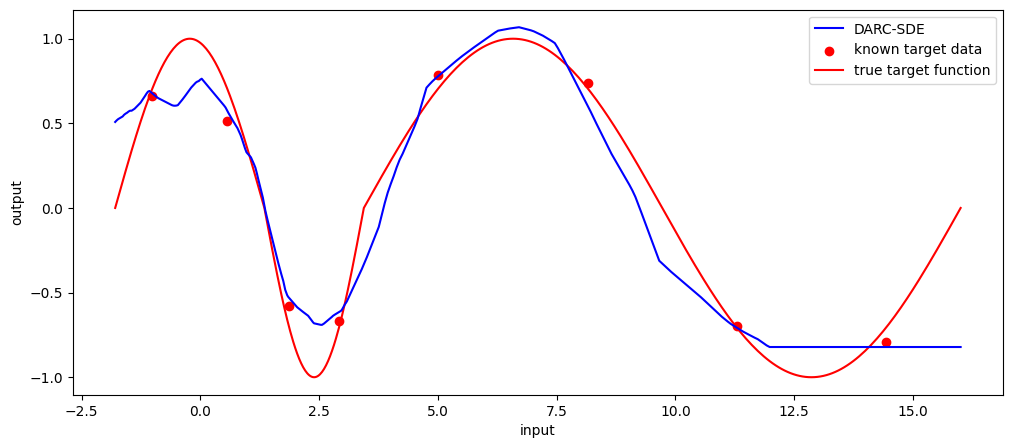

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

MLPR = MLPRegressor(hidden_layer_sizes=(30,30), validation_fraction=0.1)
# MLPR = LinearRegression()
latent_source_x = torch.tensor([])
latent_source_y = torch.tensor([])
for i in range(5):
    latent_source_x = torch.cat([latent_source_x, model.forward(eval(f"x_t{i}"), eval(f"x_t{i}"))[0].detach()], axis=0)
    latent_source_y = torch.cat([latent_source_y, eval(f"y_t{i}")], axis=0)
latent_source_x = torch.cat([latent_source_x, model.forward(x_t_labeled, x_t_labeled)[0].detach()], axis=0)
latent_source_y = torch.cat([latent_source_y, y_t_labeled], axis=0)
latent_source_x = np.array(latent_source_x)
latent_source_y = np.array(latent_source_y)
latent_target_x = model.forward(x_t, x_t)[0].detach().numpy()

MLPR.fit(latent_source_x, latent_source_y)
print(f"test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t)}, denoised test mse : {mean_squared_error(MLPR.predict(latent_target_x), y_t_true)}")

plt.figure(figsize=(12,5))
plt.plot(x_t[:,[0]], MLPR.predict(latent_target_x), c='blue', label='DARC-SDE', zorder=2)
plt.scatter(x_t_labeled[:,[0]], y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t[:,[0]], y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
